<a href="https://colab.research.google.com/github/MicahSee/LTSM-Stock-Price-Prediction/blob/main/train_optimize_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Define the model and associated methods**


In [145]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=1):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - self.seq_len

    def __getitem__(self, index):
        return self.X[index:index+self.seq_len], self.y[index+self.seq_len]


class TSModel(nn.Module):
    def __init__(self, features, hidden_units=64, num_layers=2, dropout=0.5):
        super(TSModel, self).__init__()

        self.n_hidden = hidden_units
        self.lstm = nn.LSTM(
            input_size=features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=num_layers,
            dropout=dropout
        )
        self.linear = nn.Linear(hidden_units, 1)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        lstm_out = hidden[-1]  # output last hidden state output
        y_pred = self.linear(lstm_out)

        return y_pred


def train_model(
        train_df,
        test_df,
        label_name,
        sequence_length,
        batch_size,
        n_epochs,
        n_epochs_stop,
        criterion
):
    """Train LSTM model."""
    print("Starting with model training...")

    # create dataloaders
    train_dataset = TimeSeriesDataset(np.array(train_df), np.array(train_df[label_name]), seq_len=sequence_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = TimeSeriesDataset(np.array(test_df), np.array(test_df[label_name]), seq_len=sequence_length)
    test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

    # set up training
    n_features = train_df.shape[1]
    model = TSModel(n_features)
    model = model.to(device)
    # criterion = torch.nn.MSELoss()  # L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_hist = []
    test_hist = []

    # start training
    best_loss = np.inf
    epochs_no_improve = 0

    for epoch in range(1, n_epochs+1):
        running_loss = 0
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader, 1):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            data = torch.Tensor(np.array(data)).to(device)
            output = model(data)
            loss = criterion(output.flatten(), target.type_as(output))
            # if type(criterion) == torch.nn.modules.loss.MSELoss:
            #     loss = torch.sqrt(loss)  # RMSE
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        running_loss /= len(train_loader)
        train_hist.append(running_loss)

        # test loss
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                data = torch.Tensor(np.array(data)).to(device)
                output = model(data)
                loss = criterion(output.flatten(), target.type_as(output))
                test_loss += loss.item()

            test_loss /= len(test_loader)
            test_hist.append(test_loss)

            # early stopping
            if test_loss < best_loss:
                best_loss = test_loss
                torch.save(model.state_dict(), 'model.pt')
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve == n_epochs_stop:
                print("Early stopping.")
                break

        print(f'Epoch {epoch} train loss: {round(running_loss,4)} test loss: {round(test_loss,4)}')

        hist = pd.DataFrame()
        hist['training_loss'] = train_hist
        hist['test_loss'] = test_hist

    print("Completed.")

    hist.plot(figsize=(12,6))
    plt.show()

    return hist

**Set global params**

In [147]:
sequence_length = 30
num_features = 5

In [150]:
inference_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import requests

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&outputsize=full&datatype=csv&apikey=ZN0OVWTE2EQWLSVI'

r = requests.get(url)
with open('IBM_daily.csv', 'wb') as f:
    f.write(r.content)

In [3]:
stock_df = pd.read_csv('IBM_daily.csv')

In [73]:
stock_df2 = pd.read_csv('IBM_daily.csv')

In [76]:
stock_df2 = stock_df2[::-1].set_index(stock_df2.index)
stock_df2.iloc[4901, :]

timestamp    2019-04-26
open             139.34
high             139.89
low              138.81
close            139.44
volume          2319834
Name: 4901, dtype: object

In [4]:
stock_df

,timestamp,open,high,low,close,volume
0,2024-01-12,162.97,165.9800,162.355,165.80,4958261
1,2024-01-11,161.02,162.2300,160.290,162.16,3778395
2,2024-01-10,160.28,161.3400,159.740,161.23,2967852
3,2024-01-09,160.00,160.4837,159.510,160.08,2617186
4,2024-01-08,158.69,161.2160,157.885,161.14,3321698
...,...,...,...,...,...,...
6084,1999-11-05,92.75,92.9400,90.190,90.25,13737600
6085,1999-11-04,94.44,94.4400,90.000,91.56,16697600
6086,1999-11-03,95.87,95.9400,93.500,94.37,10369100
6087,1999-11-02,96.75,96.8100,93.690,94.81,11105400


In [16]:
from sklearn.preprocessing import StandardScaler

model_df = stock_df.drop(['timestamp'], axis=1)

feature_scaler = StandardScaler()
model_df[['open', 'high', 'low', 'close', 'volume']] = feature_scaler.fit_transform(model_df[['open', 'high', 'low', 'close', 'volume']])

In [17]:
# View stats about columns

model_df.describe()

,open,high,low,close,volume
count,6089.000000,6089.000000,6089.000000,6.089000e+03,6089.000000
mean,0.000000,0.000000,0.000000,-7.468342e-17,0.000000
std,1.000082,1.000082,1.000082,1.000082e+00,1.000082
min,-2.130843,-2.102948,-2.120618,-2.119931e+00,-1.742427
25%,-0.857051,-0.844903,-0.854881,-8.488191e-01,-0.658035
50%,-0.059797,-0.064672,-0.055498,-5.720627e-02,-0.250458
75%,0.651328,0.646533,0.655663,6.514218e-01,0.363111
max,2.422907,2.400780,2.426333,2.432338e+00,10.664373


In [18]:
# Set time order from oldest to most recent
model_df = model_df[::-1].set_index(model_df.index)

In [22]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(model_df, test_size=0.2, shuffle=False)

In [23]:
train_df

,open,high,low,close,volume
0,-0.888499,-0.911667,-0.918990,-0.939451,1.088641
1,-0.938079,-0.968246,-0.995014,-0.994397,1.558602
2,-0.963011,-0.992858,-1.000404,-1.006858,1.335872
3,-1.003525,-1.035293,-1.099688,-1.086445,3.250232
4,-1.051406,-1.077728,-1.094299,-1.123547,2.354838
...,...,...,...,...,...
4866,0.191221,0.165607,0.166332,0.154079,-0.482232
4867,0.123225,0.118929,0.136547,0.146432,-0.659218
4868,0.174789,0.189370,0.200656,0.220637,-0.609065
4869,0.245335,0.245101,0.257958,0.236781,-0.604486


Starting with model training...
Epoch 1 train loss: 0.7097 test loss: 0.0838
Epoch 2 train loss: 0.1583 test loss: 0.0177
Epoch 3 train loss: 0.2065 test loss: 0.0308
Epoch 4 train loss: 0.0691 test loss: 0.0148
Epoch 5 train loss: 0.0526 test loss: 0.0134
Epoch 6 train loss: 0.0374 test loss: 0.0107
Epoch 7 train loss: 0.038 test loss: 0.01
Epoch 8 train loss: 0.0406 test loss: 0.0094
Epoch 9 train loss: 0.036 test loss: 0.009
Epoch 10 train loss: 0.0306 test loss: 0.0086
Epoch 11 train loss: 0.0268 test loss: 0.0085
Epoch 12 train loss: 0.025 test loss: 0.0086
Epoch 13 train loss: 0.0272 test loss: 0.0088
Epoch 14 train loss: 0.0339 test loss: 0.0091
Epoch 15 train loss: 0.0425 test loss: 0.0091
Early stopping.
Completed.


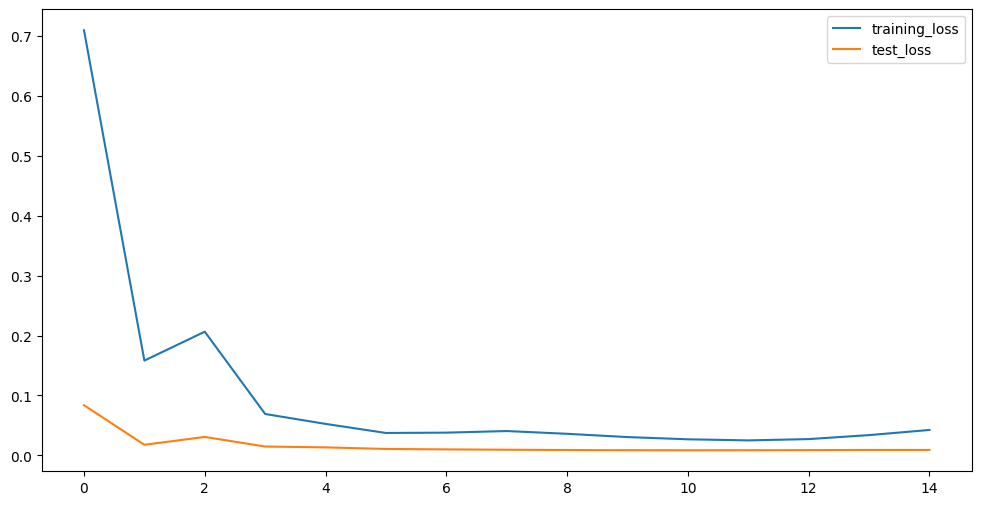

In [95]:
hist = train_model(
    train_df=train_df,
    test_df=test_df,
    label_name='close',
    sequence_length=30,
    batch_size=100,
    n_epochs=200,
    n_epochs_stop=5,
    criterion=nn.MSELoss()
)

In [173]:
def compute_comp_error(trunc_df):

  # Calculate the mean squared error.
  mse = np.mean((trunc_df['label_close'].values - trunc_df['pred_close'].values) ** 2)

  # Return the mean squared error.
  return mse

def predict(
        df,
        label_name,
        sequence_length,
        scaler
):
    """Make predictions."""

    model = TSModel(df.shape[1])
    model.load_state_dict(torch.load('model.pt'))
    model.eval()

    test_dataset = TimeSeriesDataset(np.array(df), np.array(df[label_name]), seq_len=sequence_length)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    predictions = []
    labels = []
    with torch.no_grad():
        for features, target in test_loader:
            features = torch.Tensor(np.array(features))
            output = model(features)
            predictions.append(output.item())
            labels.append(target.item())

    # bring predictions back to original scale
    descaler = StandardScaler()
    descaler.mean_, descaler.scale_ = scaler.mean_[-2], scaler.scale_[-2]
    predictions_descaled = descaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    labels_descaled = descaler.inverse_transform(np.array(labels).reshape(-1, 1)).flatten()

    return predictions_descaled, labels_descaled

def predict_after_ray(
  df,
  label_name,
  sequence_length,
  scaler,
  result_grid
):
  model = TSModel(df.shape[1], **result_grid.get_best_result().config)

  with result_grid.get_best_result().checkpoint.as_directory() as checkpoint_dir:
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "checkpoint.pt")))

  model.eval()

  test_dataset = TimeSeriesDataset(np.array(df), np.array(df[label_name]), seq_len=sequence_length)
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

  predictions = []
  labels = []
  with torch.no_grad():
      for features, target in test_loader:
          features = torch.Tensor(np.array(features))
          output = model(features)
          predictions.append(output.item())
          labels.append(target.item())

  # bring predictions back to original scale
  descaler = StandardScaler()
  descaler.mean_, descaler.scale_ = scaler.mean_[-2], scaler.scale_[-2]
  predictions_descaled = descaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
  labels_descaled = descaler.inverse_transform(np.array(labels).reshape(-1, 1)).flatten()

  return predictions_descaled, labels_descaled

In [34]:
test_df

,open,high,low,close,volume
4871,0.245052,0.223601,0.263631,0.251225,-0.972283
4872,0.269417,0.262924,0.296820,0.269352,0.363216
4873,0.282449,0.264055,0.282353,0.291443,-0.812043
4874,0.314464,0.301681,0.318663,0.299374,-0.747361
4875,0.302282,0.273391,0.289729,0.274167,-0.696808
...,...,...,...,...,...
6084,0.816785,0.853784,0.826007,0.884232,-0.795954
6085,0.853899,0.833067,0.872104,0.854211,-1.009068
6086,0.861832,0.857291,0.878628,0.886781,-0.902992
6087,0.882798,0.882469,0.894230,0.913121,-0.657804


In [96]:
predictions_descaled, labels_descaled = predict(df=test_df,
                                                label_name='close',
                                                sequence_length=sequence_length,
                                                scaler=feature_scaler)

In [97]:
predictions_descaled

array([139.77863125, 139.3223818 , 138.994489  , ..., 158.3638689 ,
       158.28043808, 158.55876882])

In [98]:
labels_descaled

array([139.44, 139.05, 140.27, ..., 161.23, 162.16, 165.8 ])

In [189]:
def prep_data_for_plot(
        orig_df,
        inf_df,
        predictions,
):

  trunc_df = orig_df[::-1].set_index(orig_df.index).iloc[-(len(inf_df)-sequence_length):, :]
  trunc_df = trunc_df[['timestamp', 'close']]
  trunc_df[['timestamp', 'label_close']] = trunc_df[['timestamp', 'close']]
  trunc_df['pred_close'] = predictions_descaled
  trunc_df['timestamp'] = pd.to_datetime(trunc_df['timestamp'])
  trunc_df = trunc_df.drop(['close'], axis=1)
  return trunc_df

In [91]:
data2 = prep_data_for_plot(orig_df=stock_df, predictions=predictions_descaled)
data2

,timestamp,label_close,pred_close
4901,2019-04-26,139.44,140.586612
4902,2019-04-29,139.05,140.245571
4903,2019-04-30,140.27,139.818429
4904,2019-05-01,140.56,139.466933
4905,2019-05-02,139.59,139.691897
...,...,...,...
6084,2024-01-08,161.14,159.994533
6085,2024-01-09,160.08,159.537328
6086,2024-01-10,161.23,159.304530
6087,2024-01-11,162.16,159.268832


In [92]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_predictions_labels(
        trunc_df,
        trial_name
):

  plt.plot(trunc_df['timestamp'].values, trunc_df['label_close'].values)
  plt.plot(trunc_df['timestamp'].values, trunc_df['pred_close'].values)

  plt.legend(['Actual', 'Predicted'])
  plt.title('IBM Stock Price Prediction' + ' (' + trial_name + ')')
  plt.xlabel('Date')
  plt.ylabel('Stock Price ($)')
  plt.show()

  return

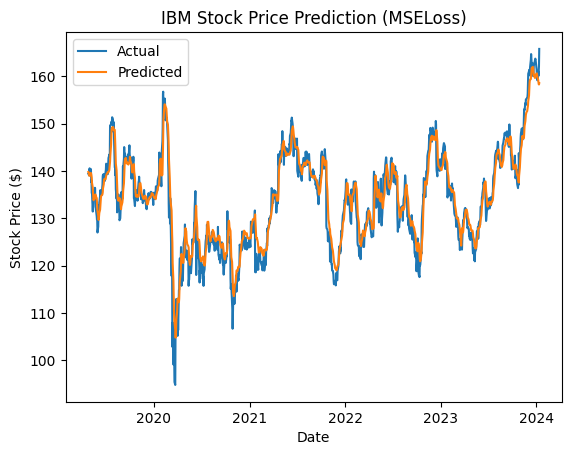

In [99]:
data2 = prep_data_for_plot(orig_df=stock_df, predictions=predictions_descaled)
plot_predictions_labels(trunc_df=data2, trial_name='MSELoss')

In [104]:
compute_comp_error(trunc_df=data2)

10.66365472638669

Starting with model training...
Epoch 1 train loss: 0.6938 test loss: 0.2229
Epoch 2 train loss: 0.3699 test loss: 0.1734
Epoch 3 train loss: 0.3555 test loss: 0.0783
Epoch 4 train loss: 0.2697 test loss: 0.1182
Epoch 5 train loss: 0.2773 test loss: 0.1191
Epoch 6 train loss: 0.1837 test loss: 0.0814
Epoch 7 train loss: 0.1396 test loss: 0.0699
Epoch 8 train loss: 0.1451 test loss: 0.0743
Epoch 9 train loss: 0.1697 test loss: 0.0687
Epoch 10 train loss: 0.1488 test loss: 0.0699
Epoch 11 train loss: 0.1487 test loss: 0.069
Epoch 12 train loss: 0.1435 test loss: 0.0662
Epoch 13 train loss: 0.1342 test loss: 0.066
Epoch 14 train loss: 0.1324 test loss: 0.0646
Epoch 15 train loss: 0.1309 test loss: 0.0627
Epoch 16 train loss: 0.123 test loss: 0.063
Epoch 17 train loss: 0.1244 test loss: 0.0631
Epoch 18 train loss: 0.1281 test loss: 0.0622
Epoch 19 train loss: 0.1298 test loss: 0.0618
Epoch 20 train loss: 0.1269 test loss: 0.0617
Epoch 21 train loss: 0.1232 test loss: 0.0623
Epoch 22 train 

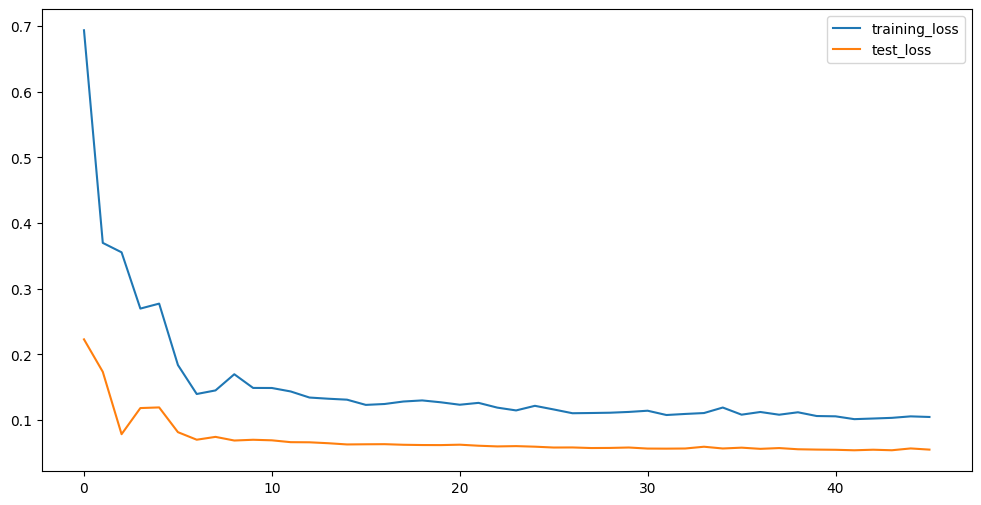

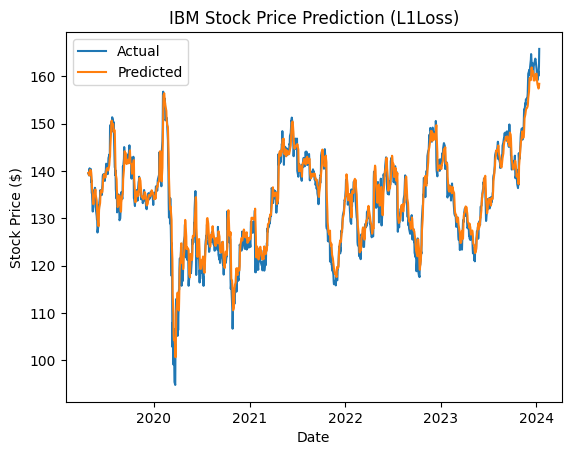

In [106]:
hist = train_model(
    train_df=train_df,
    test_df=test_df,
    label_name='close',
    sequence_length=30,
    batch_size=100,
    n_epochs=200,
    n_epochs_stop=5,
    criterion=nn.L1Loss()
)

predictions_descaled, labels_descaled = predict(df=test_df,
                                                label_name='close',
                                                sequence_length=sequence_length,
                                                scaler=feature_scaler)

data3 = prep_data_for_plot(orig_df=stock_df, predictions=predictions_descaled)
plot_predictions_labels(trunc_df=data3, trial_name='L1Loss')

In [107]:
compute_comp_error(trunc_df=data3)

7.082196184324341

Starting with model training...
Epoch 1 train loss: 0.3173 test loss: 0.0309
Epoch 2 train loss: 0.0669 test loss: 0.0128
Epoch 3 train loss: 0.1006 test loss: 0.0098
Epoch 4 train loss: 0.0452 test loss: 0.0103
Epoch 5 train loss: 0.0216 test loss: 0.008
Epoch 6 train loss: 0.0131 test loss: 0.0053
Epoch 7 train loss: 0.0121 test loss: 0.0047
Epoch 8 train loss: 0.0148 test loss: 0.0047
Epoch 9 train loss: 0.0181 test loss: 0.0047
Epoch 10 train loss: 0.017 test loss: 0.0044
Epoch 11 train loss: 0.0128 test loss: 0.0043
Epoch 12 train loss: 0.0113 test loss: 0.0045
Epoch 13 train loss: 0.013 test loss: 0.0046
Epoch 14 train loss: 0.0187 test loss: 0.005
Epoch 15 train loss: 0.0238 test loss: 0.0051
Early stopping.
Completed.


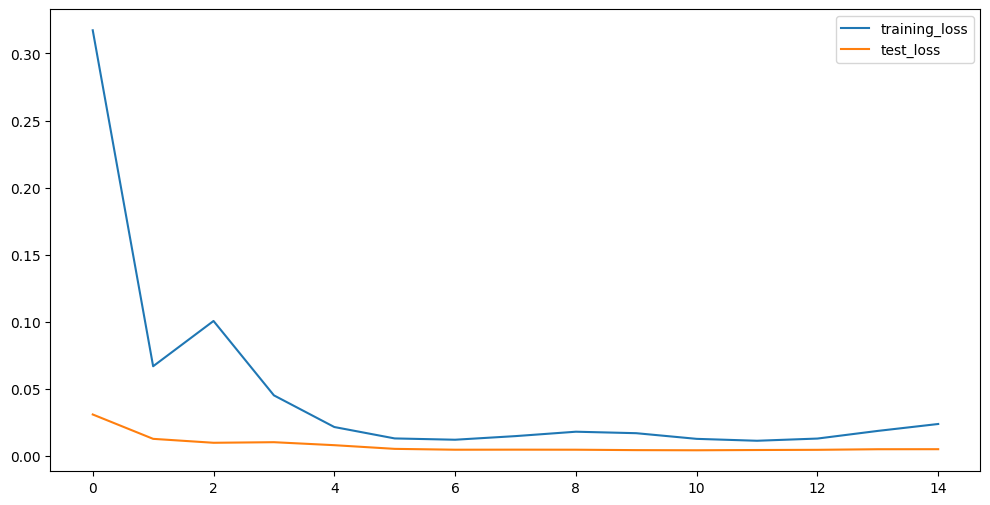

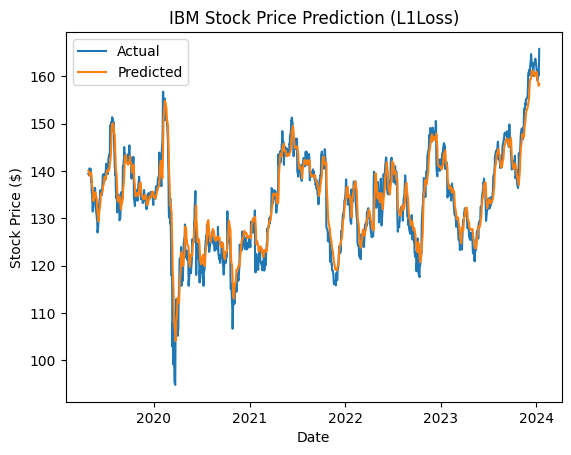

In [110]:
hist = train_model(
    train_df=train_df,
    test_df=test_df,
    label_name='close',
    sequence_length=30,
    batch_size=100,
    n_epochs=200,
    n_epochs_stop=5,
    criterion=nn.HuberLoss()
)

predictions_descaled, labels_descaled = predict(df=test_df,
                                                label_name='close',
                                                sequence_length=sequence_length,
                                                scaler=feature_scaler)

data4 = prep_data_for_plot(orig_df=stock_df, predictions=predictions_descaled)
plot_predictions_labels(trunc_df=data4, trial_name='HuberLoss')

In [111]:
compute_comp_error(trunc_df=data4)

10.637047542641035

In [128]:
train_dataset = TimeSeriesDataset(np.array(train_df), np.array(train_df['close']), seq_len=sequence_length)
X_train = [item[0] for item in train_dataset]
np.array(X_train[:10]).shape

(10, 30, 5)

In [135]:
!pip install ray[tune]

In [178]:
import os
import tempfile
from ray import tune, train
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler

# Create a Ray cluster.
# ray.init()

# Define the search space for the hyperparameters.
search_space = {
    "num_layers": tune.choice([2, 3, 4]),
    "hidden_units": tune.choice([16, 32, 64]),
    "dropout": tune.choice([0.0, 0.2, 0.4]),
}

epochs = 100
batch_size = 100

# Setup the dataloaders
train_df, test_df = train_test_split(model_df, test_size=0.2, shuffle=False)

train_dataset = TimeSeriesDataset(np.array(train_df), np.array(train_df['close']), seq_len=sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TimeSeriesDataset(np.array(test_df), np.array(test_df['close']), seq_len=sequence_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def train_model_ray(config):
    # allocate hardware
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"

    # set up training
    n_features = train_df.shape[1]
    model = TSModel(n_features, hidden_units=config['hidden_units'], num_layers=config['num_layers'], dropout=config['dropout'])
    model = model.to(device)
    criterion = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_hist = []
    test_hist = []

    # start training
    best_loss = np.inf
    epochs_no_improve = 0

    for epoch in range(1, epochs+1):
        running_loss = 0
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader, 1):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            data = torch.Tensor(np.array(data)).to(device)
            output = model(data)
            loss = criterion(output.flatten(), target.type_as(output))
            # if type(criterion) == torch.nn.modules.loss.MSELoss:
            #     loss = torch.sqrt(loss)  # RMSE
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        running_loss /= len(train_loader)
        train_hist.append(running_loss)

        # test loss
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                data = torch.Tensor(np.array(data)).to(device)
                output = model(data)
                loss = criterion(output.flatten(), target.type_as(output))
                test_loss += loss.item()

            test_loss /= len(test_loader)

    with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
        path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
        torch.save(model.state_dict(), path)
        checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
        train.report({"loss": test_loss}, checkpoint=checkpoint)

    return

In [179]:
num_optim_trials = 27

tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_model_ray),
            resources={"cpu": 2, "gpu": 1}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=ASHAScheduler(),
            num_samples=num_optim_trials,
        ),
        param_space=search_space,
)

results = tuner.fit()

2024-01-13 23:59:45,202	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+------------------------------------------------------------------------+
| Configuration for experiment     train_model_ray_2024-01-13_23-59-45   |
+------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                 |
| Scheduler                        AsyncHyperBandScheduler               |
| Number of trials                 27                                    |
+------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_ray_2024-01-13_23-59-45
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/train_model_ray_2024-01-13_23-59-45`

Trial status: 16 PENDING
Current time: 2024-01-13 23:59:45. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+------------------------------------------------------------------------------------+
| Trial name          

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00000_0_dropout=0.4000,hidden_units=16,num_layers=3_2024-01-13_23-59-45/checkpoint_000000)



Trial status: 1 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2024-01-14 00:00:15. Total running time: 30s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: d35b6_00000 with loss=0.08949339110404253 and params={'num_layers': 3, 'hidden_units': 16, 'dropout': 0.4}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name                    status         num_layers     hidden_units     dropout     iter     total time (s)        loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_model_ray_d35b6_00001   RUNNING                 3               64         0                                           |
| train_model_ray_d35b6_00000   TERMINATED              3               16         0.4        1            19.8619   0.0894934 |
| train_model_ray_d35b6_00002   PENDING

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00001_1_dropout=0.0000,hidden_units=64,num_layers=3_2024-01-13_23-59-45/checkpoint_000000)



Trial status: 2 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2024-01-14 00:00:45. Total running time: 1min 0s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: d35b6_00001 with loss=0.044540409153948225 and params={'num_layers': 3, 'hidden_units': 64, 'dropout': 0.0}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name                    status         num_layers     hidden_units     dropout     iter     total time (s)        loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_model_ray_d35b6_00002   RUNNING                 4               16         0.4                                         |
| train_model_ray_d35b6_00000   TERMINATED              3               16         0.4        1            19.8619   0.0894934 |
| train_model_ray_d35b6_00001   TE

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00002_2_dropout=0.4000,hidden_units=16,num_layers=4_2024-01-13_23-59-45/checkpoint_000000)



Trial train_model_ray_d35b6_00003 completed after 1 iterations at 2024-01-14 00:01:04. Total running time: 1min 18s
+----------------------------------------------------------------+
| Trial train_model_ray_d35b6_00003 result                       |
+----------------------------------------------------------------+
| checkpoint_dir_name                          checkpoint_000000 |
| time_this_iter_s                                      17.17411 |
| time_total_s                                          17.17411 |
| training_iteration                                           1 |
| loss                                                   0.05097 |
+----------------------------------------------------------------+

Trial train_model_ray_d35b6_00004 started with configuration:
+-------------------------------------------------+
| Trial train_model_ray_d35b6_00004 config        |
+-------------------------------------------------+
| dropout                                       0 |
| hidden_

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00003_3_dropout=0.2000,hidden_units=32,num_layers=2_2024-01-13_23-59-45/checkpoint_000000)



Trial status: 4 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2024-01-14 00:01:15. Total running time: 1min 30s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: d35b6_00001 with loss=0.044540409153948225 and params={'num_layers': 3, 'hidden_units': 64, 'dropout': 0.0}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name                    status         num_layers     hidden_units     dropout     iter     total time (s)        loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_model_ray_d35b6_00004   RUNNING                 3               64         0                                           |
| train_model_ray_d35b6_00000   TERMINATED              3               16         0.4        1            19.8619   0.0894934 |
| train_model_ray_d35b6_00001   T

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00004_4_dropout=0.0000,hidden_units=64,num_layers=3_2024-01-13_23-59-45/checkpoint_000000)



Trial train_model_ray_d35b6_00005 completed after 1 iterations at 2024-01-14 00:01:42. Total running time: 1min 56s
+----------------------------------------------------------------+
| Trial train_model_ray_d35b6_00005 result                       |
+----------------------------------------------------------------+
| checkpoint_dir_name                          checkpoint_000000 |
| time_this_iter_s                                      19.09319 |
| time_total_s                                          19.09319 |
| training_iteration                                           1 |
| loss                                                   0.07752 |
+----------------------------------------------------------------+

Trial train_model_ray_d35b6_00006 started with configuration:
+--------------------------------------------------+
| Trial train_model_ray_d35b6_00006 config         |
+--------------------------------------------------+
| dropout                                      0.4 |
| hid

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00005_5_dropout=0.4000,hidden_units=32,num_layers=4_2024-01-13_23-59-45/checkpoint_000000)



Trial status: 6 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2024-01-14 00:01:45. Total running time: 2min 0s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: d35b6_00001 with loss=0.044540409153948225 and params={'num_layers': 3, 'hidden_units': 64, 'dropout': 0.0}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name                    status         num_layers     hidden_units     dropout     iter     total time (s)        loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_model_ray_d35b6_00006   RUNNING                 3               16         0.4                                         |
| train_model_ray_d35b6_00000   TERMINATED              3               16         0.4        1            19.8619   0.0894934 |
| train_model_ray_d35b6_00001   TE

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00006_6_dropout=0.4000,hidden_units=16,num_layers=3_2024-01-13_23-59-45/checkpoint_000000)



Trial status: 7 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2024-01-14 00:02:15. Total running time: 2min 30s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: d35b6_00001 with loss=0.044540409153948225 and params={'num_layers': 3, 'hidden_units': 64, 'dropout': 0.0}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name                    status         num_layers     hidden_units     dropout     iter     total time (s)        loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_model_ray_d35b6_00007   RUNNING                 3               32         0                                           |
| train_model_ray_d35b6_00000   TERMINATED              3               16         0.4        1            19.8619   0.0894934 |
| train_model_ray_d35b6_00001   T

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00007_7_dropout=0.0000,hidden_units=32,num_layers=3_2024-01-13_23-59-45/checkpoint_000000)



Trial train_model_ray_d35b6_00008 completed after 1 iterations at 2024-01-14 00:02:36. Total running time: 2min 50s
+----------------------------------------------------------------+
| Trial train_model_ray_d35b6_00008 result                       |
+----------------------------------------------------------------+
| checkpoint_dir_name                          checkpoint_000000 |
| time_this_iter_s                                       17.5701 |
| time_total_s                                           17.5701 |
| training_iteration                                           1 |
| loss                                                   0.06843 |
+----------------------------------------------------------------+

Trial train_model_ray_d35b6_00009 started with configuration:
+--------------------------------------------------+
| Trial train_model_ray_d35b6_00009 config         |
+--------------------------------------------------+
| dropout                                      0.4 |
| hid

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00008_8_dropout=0.2000,hidden_units=16,num_layers=3_2024-01-13_23-59-45/checkpoint_000000)



Trial status: 9 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2024-01-14 00:02:45. Total running time: 3min 0s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: d35b6_00001 with loss=0.044540409153948225 and params={'num_layers': 3, 'hidden_units': 64, 'dropout': 0.0}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name                    status         num_layers     hidden_units     dropout     iter     total time (s)        loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_model_ray_d35b6_00009   RUNNING                 4               16         0.4                                         |
| train_model_ray_d35b6_00000   TERMINATED              3               16         0.4        1            19.8619   0.0894934 |
| train_model_ray_d35b6_00001   TE

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00009_9_dropout=0.4000,hidden_units=16,num_layers=4_2024-01-13_23-59-45/checkpoint_000000)



Trial train_model_ray_d35b6_00010 completed after 1 iterations at 2024-01-14 00:03:14. Total running time: 3min 29s
+----------------------------------------------------------------+
| Trial train_model_ray_d35b6_00010 result                       |
+----------------------------------------------------------------+
| checkpoint_dir_name                          checkpoint_000000 |
| time_this_iter_s                                      18.53451 |
| time_total_s                                          18.53451 |
| training_iteration                                           1 |
| loss                                                   0.05859 |
+----------------------------------------------------------------+

Trial train_model_ray_d35b6_00011 started with configuration:
+--------------------------------------------------+
| Trial train_model_ray_d35b6_00011 config         |
+--------------------------------------------------+
| dropout                                      0.4 |
| hid

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00010_10_dropout=0.4000,hidden_units=32,num_layers=3_2024-01-13_23-59-45/checkpoint_000000)



Trial status: 11 TERMINATED | 1 RUNNING | 15 PENDING
Current time: 2024-01-14 00:03:15. Total running time: 3min 30s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: d35b6_00001 with loss=0.044540409153948225 and params={'num_layers': 3, 'hidden_units': 64, 'dropout': 0.0}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name                    status         num_layers     hidden_units     dropout     iter     total time (s)        loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_model_ray_d35b6_00011   RUNNING                 4               32         0.4                                         |
| train_model_ray_d35b6_00000   TERMINATED              3               16         0.4        1            19.8619   0.0894934 |
| train_model_ray_d35b6_00001   

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00011_11_dropout=0.4000,hidden_units=32,num_layers=4_2024-01-13_23-59-45/checkpoint_000000)



Trial status: 12 TERMINATED | 1 RUNNING | 14 PENDING
Current time: 2024-01-14 00:03:46. Total running time: 4min 0s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: d35b6_00001 with loss=0.044540409153948225 and params={'num_layers': 3, 'hidden_units': 64, 'dropout': 0.0}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name                    status         num_layers     hidden_units     dropout     iter     total time (s)        loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_model_ray_d35b6_00012   RUNNING                 2               64         0                                           |
| train_model_ray_d35b6_00000   TERMINATED              3               16         0.4        1            19.8619   0.0894934 |
| train_model_ray_d35b6_00001   T

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00012_12_dropout=0.0000,hidden_units=64,num_layers=2_2024-01-13_23-59-45/checkpoint_000000)



Trial train_model_ray_d35b6_00013 completed after 1 iterations at 2024-01-14 00:04:12. Total running time: 4min 27s
+----------------------------------------------------------------+
| Trial train_model_ray_d35b6_00013 result                       |
+----------------------------------------------------------------+
| checkpoint_dir_name                          checkpoint_000000 |
| time_this_iter_s                                      20.16878 |
| time_total_s                                          20.16878 |
| training_iteration                                           1 |
| loss                                                   0.06697 |
+----------------------------------------------------------------+

Trial train_model_ray_d35b6_00014 started with configuration:
+--------------------------------------------------+
| Trial train_model_ray_d35b6_00014 config         |
+--------------------------------------------------+
| dropout                                      0.4 |
| hid

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00013_13_dropout=0.4000,hidden_units=64,num_layers=4_2024-01-13_23-59-45/checkpoint_000000)



Trial status: 14 TERMINATED | 1 RUNNING | 12 PENDING
Current time: 2024-01-14 00:04:16. Total running time: 4min 30s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: d35b6_00001 with loss=0.044540409153948225 and params={'num_layers': 3, 'hidden_units': 64, 'dropout': 0.0}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name                    status         num_layers     hidden_units     dropout     iter     total time (s)        loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_model_ray_d35b6_00014   RUNNING                 2               64         0.4                                         |
| train_model_ray_d35b6_00000   TERMINATED              3               16         0.4        1            19.8619   0.0894934 |
| train_model_ray_d35b6_00001   

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00014_14_dropout=0.4000,hidden_units=64,num_layers=2_2024-01-13_23-59-45/checkpoint_000000)



Trial train_model_ray_d35b6_00014 completed after 1 iterations at 2024-01-14 00:04:30. Total running time: 4min 44s
+----------------------------------------------------------------+
| Trial train_model_ray_d35b6_00014 result                       |
+----------------------------------------------------------------+
| checkpoint_dir_name                          checkpoint_000000 |
| time_this_iter_s                                      17.55225 |
| time_total_s                                          17.55225 |
| training_iteration                                           1 |
| loss                                                   0.04806 |
+----------------------------------------------------------------+

Trial train_model_ray_d35b6_00015 started with configuration:
+--------------------------------------------------+
| Trial train_model_ray_d35b6_00015 config         |
+--------------------------------------------------+
| dropout                                      0.2 |
| hid

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00015_15_dropout=0.2000,hidden_units=32,num_layers=3_2024-01-13_23-59-45/checkpoint_000000)



Trial train_model_ray_d35b6_00016 completed after 1 iterations at 2024-01-14 00:05:06. Total running time: 5min 21s
+----------------------------------------------------------------+
| Trial train_model_ray_d35b6_00016 result                       |
+----------------------------------------------------------------+
| checkpoint_dir_name                          checkpoint_000000 |
| time_this_iter_s                                      17.86442 |
| time_total_s                                          17.86442 |
| training_iteration                                           1 |
| loss                                                   0.05406 |
+----------------------------------------------------------------+

Trial train_model_ray_d35b6_00017 started with configuration:
+--------------------------------------------------+
| Trial train_model_ray_d35b6_00017 config         |
+--------------------------------------------------+
| dropout                                      0.2 |
| hid

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00016_16_dropout=0.0000,hidden_units=32,num_layers=3_2024-01-13_23-59-49/checkpoint_000000)



Trial status: 17 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2024-01-14 00:05:16. Total running time: 5min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: d35b6_00001 with loss=0.044540409153948225 and params={'num_layers': 3, 'hidden_units': 64, 'dropout': 0.0}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name                    status         num_layers     hidden_units     dropout     iter     total time (s)        loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_model_ray_d35b6_00017   RUNNING                 4               16         0.2                                         |
| train_model_ray_d35b6_00000   TERMINATED              3               16         0.4        1            19.8619   0.0894934 |
| train_model_ray_d35b6_00001   T

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00017_17_dropout=0.2000,hidden_units=16,num_layers=4_2024-01-14_00-00-09/checkpoint_000000)



Trial train_model_ray_d35b6_00018 completed after 1 iterations at 2024-01-14 00:05:44. Total running time: 5min 59s
+----------------------------------------------------------------+
| Trial train_model_ray_d35b6_00018 result                       |
+----------------------------------------------------------------+
| checkpoint_dir_name                          checkpoint_000000 |
| time_this_iter_s                                      19.47998 |
| time_total_s                                          19.47998 |
| training_iteration                                           1 |
| loss                                                    0.0587 |
+----------------------------------------------------------------+

Trial train_model_ray_d35b6_00019 started with configuration:
+-------------------------------------------------+
| Trial train_model_ray_d35b6_00019 config        |
+-------------------------------------------------+
| dropout                                       0 |
| hidden_

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00018_18_dropout=0.4000,hidden_units=64,num_layers=3_2024-01-14_00-00-28/checkpoint_000000)



Trial status: 19 TERMINATED | 1 RUNNING | 7 PENDING
Current time: 2024-01-14 00:05:46. Total running time: 6min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: d35b6_00001 with loss=0.044540409153948225 and params={'num_layers': 3, 'hidden_units': 64, 'dropout': 0.0}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name                    status         num_layers     hidden_units     dropout     iter     total time (s)        loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_model_ray_d35b6_00019   RUNNING                 4               64         0                                           |
| train_model_ray_d35b6_00000   TERMINATED              3               16         0.4        1            19.8619   0.0894934 |
| train_model_ray_d35b6_00001   TE

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00019_19_dropout=0.0000,hidden_units=64,num_layers=4_2024-01-14_00-00-47/checkpoint_000000)



Trial status: 20 TERMINATED | 1 RUNNING | 6 PENDING
Current time: 2024-01-14 00:06:16. Total running time: 6min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: d35b6_00001 with loss=0.044540409153948225 and params={'num_layers': 3, 'hidden_units': 64, 'dropout': 0.0}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name                    status         num_layers     hidden_units     dropout     iter     total time (s)        loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_model_ray_d35b6_00020   RUNNING                 3               64         0                                           |
| train_model_ray_d35b6_00000   TERMINATED              3               16         0.4        1            19.8619   0.0894934 |
| train_model_ray_d35b6_00001   T

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00020_20_dropout=0.0000,hidden_units=64,num_layers=3_2024-01-14_00-01-04/checkpoint_000000)



Trial train_model_ray_d35b6_00021 completed after 1 iterations at 2024-01-14 00:06:41. Total running time: 6min 56s
+----------------------------------------------------------------+
| Trial train_model_ray_d35b6_00021 result                       |
+----------------------------------------------------------------+
| checkpoint_dir_name                          checkpoint_000000 |
| time_this_iter_s                                      17.83925 |
| time_total_s                                          17.83925 |
| training_iteration                                           1 |
| loss                                                   0.05524 |
+----------------------------------------------------------------+

Trial train_model_ray_d35b6_00022 started with configuration:
+--------------------------------------------------+
| Trial train_model_ray_d35b6_00022 config         |
+--------------------------------------------------+
| dropout                                      0.2 |
| hid

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00021_21_dropout=0.0000,hidden_units=16,num_layers=3_2024-01-14_00-01-23/checkpoint_000000)



Trial status: 22 TERMINATED | 1 RUNNING | 4 PENDING
Current time: 2024-01-14 00:06:46. Total running time: 7min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: d35b6_00001 with loss=0.044540409153948225 and params={'num_layers': 3, 'hidden_units': 64, 'dropout': 0.0}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name                    status         num_layers     hidden_units     dropout     iter     total time (s)        loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_model_ray_d35b6_00022   RUNNING                 4               16         0.2                                         |
| train_model_ray_d35b6_00000   TERMINATED              3               16         0.4        1            19.8619   0.0894934 |
| train_model_ray_d35b6_00001   TE

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00022_22_dropout=0.2000,hidden_units=16,num_layers=4_2024-01-14_00-01-42/checkpoint_000000)



Trial status: 23 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-01-14 00:07:16. Total running time: 7min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: d35b6_00001 with loss=0.044540409153948225 and params={'num_layers': 3, 'hidden_units': 64, 'dropout': 0.0}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name                    status         num_layers     hidden_units     dropout     iter     total time (s)        loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_model_ray_d35b6_00023   RUNNING                 4               64         0.2                                         |
| train_model_ray_d35b6_00000   TERMINATED              3               16         0.4        1            19.8619   0.0894934 |
| train_model_ray_d35b6_00001   T

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00023_23_dropout=0.2000,hidden_units=64,num_layers=4_2024-01-14_00-02-00/checkpoint_000000)



Trial train_model_ray_d35b6_00024 completed after 1 iterations at 2024-01-14 00:07:37. Total running time: 7min 52s
+----------------------------------------------------------------+
| Trial train_model_ray_d35b6_00024 result                       |
+----------------------------------------------------------------+
| checkpoint_dir_name                          checkpoint_000000 |
| time_this_iter_s                                      16.95601 |
| time_total_s                                          16.95601 |
| training_iteration                                           1 |
| loss                                                   0.05664 |
+----------------------------------------------------------------+

Trial train_model_ray_d35b6_00025 started with configuration:
+--------------------------------------------------+
| Trial train_model_ray_d35b6_00025 config         |
+--------------------------------------------------+
| dropout                                      0.4 |
| hid

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00024_24_dropout=0.2000,hidden_units=16,num_layers=2_2024-01-14_00-02-18/checkpoint_000000)



Trial status: 25 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-01-14 00:07:46. Total running time: 8min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: d35b6_00001 with loss=0.044540409153948225 and params={'num_layers': 3, 'hidden_units': 64, 'dropout': 0.0}
+------------------------------------------------------------------------------------------------------------------------------+
| Trial name                    status         num_layers     hidden_units     dropout     iter     total time (s)        loss |
+------------------------------------------------------------------------------------------------------------------------------+
| train_model_ray_d35b6_00025   RUNNING                 2               64         0.4                                         |
| train_model_ray_d35b6_00000   TERMINATED              3               16         0.4        1            19.8619   0.0894934 |
| train_model_ray_d35b6_00001   TE

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00025_25_dropout=0.4000,hidden_units=64,num_layers=2_2024-01-14_00-02-36/checkpoint_000000)



Trial train_model_ray_d35b6_00026 completed after 1 iterations at 2024-01-14 00:08:14. Total running time: 8min 29s
+----------------------------------------------------------------+
| Trial train_model_ray_d35b6_00026 result                       |
+----------------------------------------------------------------+
| checkpoint_dir_name                          checkpoint_000000 |
| time_this_iter_s                                      18.81981 |
| time_total_s                                          18.81981 |
| training_iteration                                           1 |
| loss                                                   0.04796 |
+----------------------------------------------------------------+

Trial status: 27 TERMINATED
Current time: 2024-01-14 00:08:14. Total running time: 8min 29s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: d35b6_00001 with loss=0.044540409153948225 and params={'num_layers': 3, 'hidden_units': 64

(train_model_ray pid=45802) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_model_ray_2024-01-13_23-59-45/train_model_ray_d35b6_00026_26_dropout=0.2000,hidden_units=64,num_layers=3_2024-01-14_00-02-55/checkpoint_000000)


In [176]:
results.get_best_result().checkpoint.to_directory()

'/tmp/checkpoint_tmp_6278a0774b9247899831e0fcf3b4e6c4'

In [180]:
results.get_best_result().metrics

{'loss': 0.044540409153948225,
 'timestamp': 1705190428,
 'checkpoint_dir_name': 'checkpoint_000000',
 'should_checkpoint': True,
 'done': True,
 'training_iteration': 1,
 'trial_id': 'd35b6_00001',
 'date': '2024-01-14_00-00-28',
 'time_this_iter_s': 18.532623291015625,
 'time_total_s': 18.532623291015625,
 'pid': 45802,
 'hostname': 'cb40f89fa8e1',
 'node_ip': '172.28.0.12',
 'config': {'num_layers': 3, 'hidden_units': 64, 'dropout': 0.0},
 'time_since_restore': 18.532623291015625,
 'iterations_since_restore': 1,
 'experiment_tag': '1_dropout=0.0000,hidden_units=64,num_layers=3'}

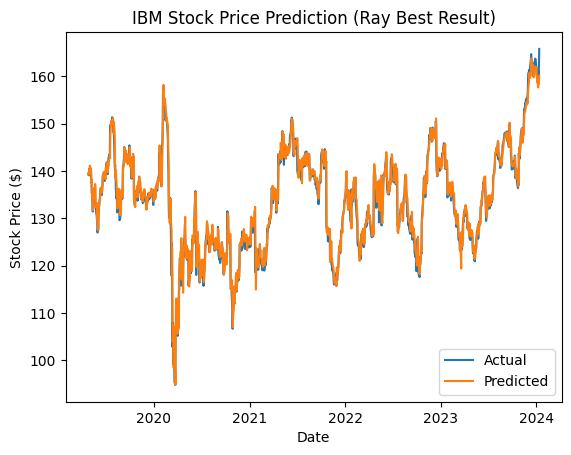

5.148300868394734

In [181]:
predictions_descaled, labels_descaled = predict_after_ray(df=test_df,
                                                label_name='close',
                                                sequence_length=sequence_length,
                                                scaler=feature_scaler,
                                                result_grid=results)

data5 = prep_data_for_plot(orig_df=stock_df, predictions=predictions_descaled)
plot_predictions_labels(trunc_df=data5, trial_name='Ray Best Result')
compute_comp_error(data5)

In [190]:
predictions_descaled, labels_descaled = predict_after_ray(df=train_df,
                                                label_name='close',
                                                sequence_length=sequence_length,
                                                scaler=feature_scaler,
                                                result_grid=results)

In [194]:
trunc_df = stock_df[::-1].set_index(stock_df.index).iloc[-(len(train_df)-sequence_length):, :]

In [196]:
train_df

,open,high,low,close,volume
0,-0.888499,-0.911667,-0.918990,-0.939451,1.088641
1,-0.938079,-0.968246,-0.995014,-0.994397,1.558602
2,-0.963011,-0.992858,-1.000404,-1.006858,1.335872
3,-1.003525,-1.035293,-1.099688,-1.086445,3.250232
4,-1.051406,-1.077728,-1.094299,-1.123547,2.354838
...,...,...,...,...,...
4866,0.191221,0.165607,0.166332,0.154079,-0.482232
4867,0.123225,0.118929,0.136547,0.146432,-0.659218
4868,0.174789,0.189370,0.200656,0.220637,-0.609065
4869,0.245335,0.245101,0.257958,0.236781,-0.604486


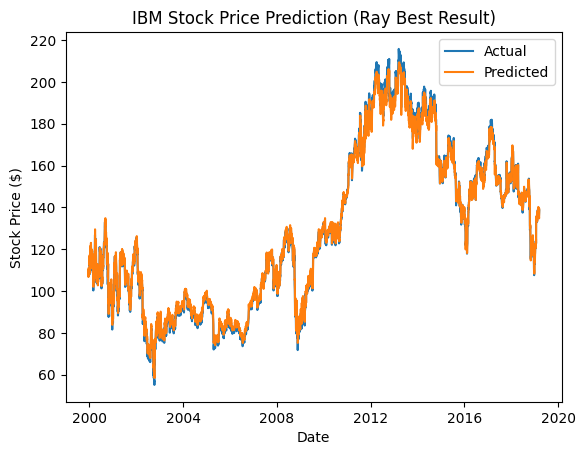

6.808139087660879

In [201]:
orig_df = stock_df[::-1].set_index(stock_df.index).iloc[:len(train_df), :]
data5 = prep_data_for_plot(orig_df=orig_df[::-1].set_index(orig_df.index), inf_df=train_df, predictions=predictions_descaled)
plot_predictions_labels(trunc_df=data5, trial_name='Ray Best Result')
compute_comp_error(data5)

In [203]:
model = TSModel(num_features, **results.get_best_result().config)

with results.get_best_result().checkpoint.as_directory() as checkpoint_dir:
  model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "checkpoint.pt")))

In [204]:
model

TSModel(
  (lstm): LSTM(5, 64, num_layers=3, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [206]:
model.eval()

test_dataset = TimeSeriesDataset(np.array(test_df), np.array(test_df['close']), seq_len=sequence_length)

In [207]:
test_dataset[0]

(array([[ 0.24505163,  0.22360095,  0.26363096,  0.25122535, -0.97228271],
        [ 0.26941687,  0.26292371,  0.29682039,  0.26935173,  0.36321577],
        [ 0.28244944,  0.2640553 ,  0.2823532 ,  0.29144325, -0.81204336],
        [ 0.31446423,  0.30168067,  0.318663  ,  0.29937354, -0.74736137],
        [ 0.30228161,  0.27339092,  0.28972863,  0.27416655, -0.69680817],
        [ 0.26176732,  0.31356237,  0.28689193,  0.32627988, -0.71012868],
        [ 0.31474755,  0.29432533,  0.28745927,  0.26991818, -0.62778988],
        [ 0.26063405,  0.25104201,  0.2718574 ,  0.26227111, -0.94173765],
        [ 0.28528261,  0.28244364,  0.30221012,  0.29172648, -1.02826969],
        [ 0.29888181,  0.26745007,  0.27327575,  0.26397046, -0.86355185],
        [ 0.28471598,  0.26603558,  0.29313267,  0.28322974, -0.99494165],
        [ 0.30143166,  0.28810159,  0.32291806,  0.31665024, -0.8625775 ],
        [ 0.33004666,  0.35005615,  0.36149721,  0.37895966, -0.59553328],
        [ 0.38217694,  0.